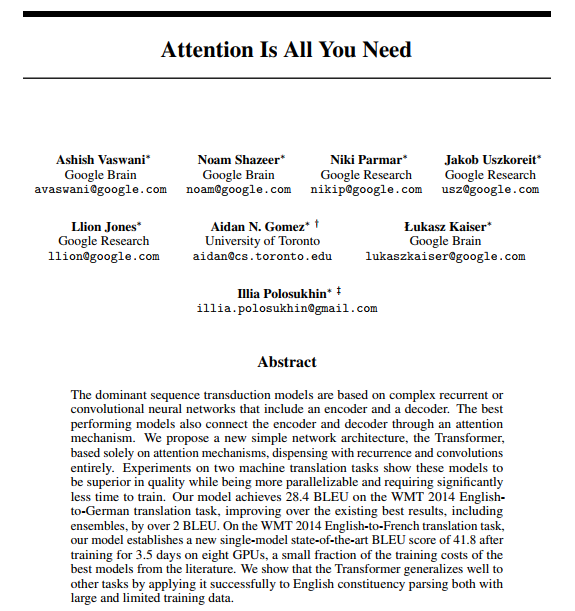

In [1]:
from IPython.display import Image
Image(filename='pictures/transformer.png')

本文翻译自哈佛NLP[The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
本文主要由Harvard NLP的学者在2018年初撰写，以逐行实现的形式呈现了论文的“注释”版本,对原始论文进行了重排，并在整个过程中添加了评论和注释。本文的note book可以在[篇章2](https://github.com/datawhalechina/learn-nlp-with-transformers/tree/main/docs/%E7%AF%87%E7%AB%A02-Transformer%E7%9B%B8%E5%85%B3%E5%8E%9F%E7%90%86)下载。

内容组织：
- Pytorch编写完整的Transformer
  - 背景
  - 模型架构
  - Encoder部分和Decoder部分
    - Encoder
    - Decoder
    - Attention
    - 模型中Attention的应用
    - 基于位置的前馈网络
  - Embeddings和softmax
  - 位置编码
  - 完整模型
- 训练
  - 批处理和mask
  - Traning Loop
  - 训练数据和批处理
  - 硬件和训练时间
  - 优化器
  - 正则化
    - 标签平滑
- 实例
  - 合成数据
  - 损失函数计算
  - 贪婪解码
- 真实场景例
- 结语
- 致谢


# 预备工作

In [2]:
# !pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext seaborn 

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

Table of Contents


* Table of Contents                               
{:toc}      

# 背景

关于Transformer的更多背景知识读者可以阅读本项目的[篇章2.2图解Transformer](https://github.com/datawhalechina/learn-nlp-with-transformers/blob/main/docs/%E7%AF%87%E7%AB%A02-Transformer%E7%9B%B8%E5%85%B3%E5%8E%9F%E7%90%86/2.2-%E5%9B%BE%E8%A7%A3transformer.md)进行学习。

# 模型架构

大部分序列到序列（seq2seq）模型都使用编码器-解码器结构 [(引用)](https://arxiv.org/abs/1409.0473)。编码器把一个输入序列$(x_{1},...x_{n})$映射到一个连续的表示$z=(z_{1},...z_{n})$中。解码器对z中的每个元素，生成输出序列$(y_{1},...y_{m})$。解码器一个时间步生成一个输出。在每一步中，模型都是自回归的[(引用)](https://arxiv.org/abs/1308.0850)，在生成下一个结果时，会将先前生成的结果加入输入序列来一起预测。现在我们先构建一个EncoderDecoder类来搭建一个seq2seq架构：

In [4]:
class EncoderDecoder(nn.Module):
    """
    基础的Encoder-Decoder结构。
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [6]:
class Generator(nn.Module):
    "定义生成器，由linear和softmax组成"
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

Transformer的编码器和解码器都使用self-attention和全连接层堆叠而成。如下图的左、右两边所示。

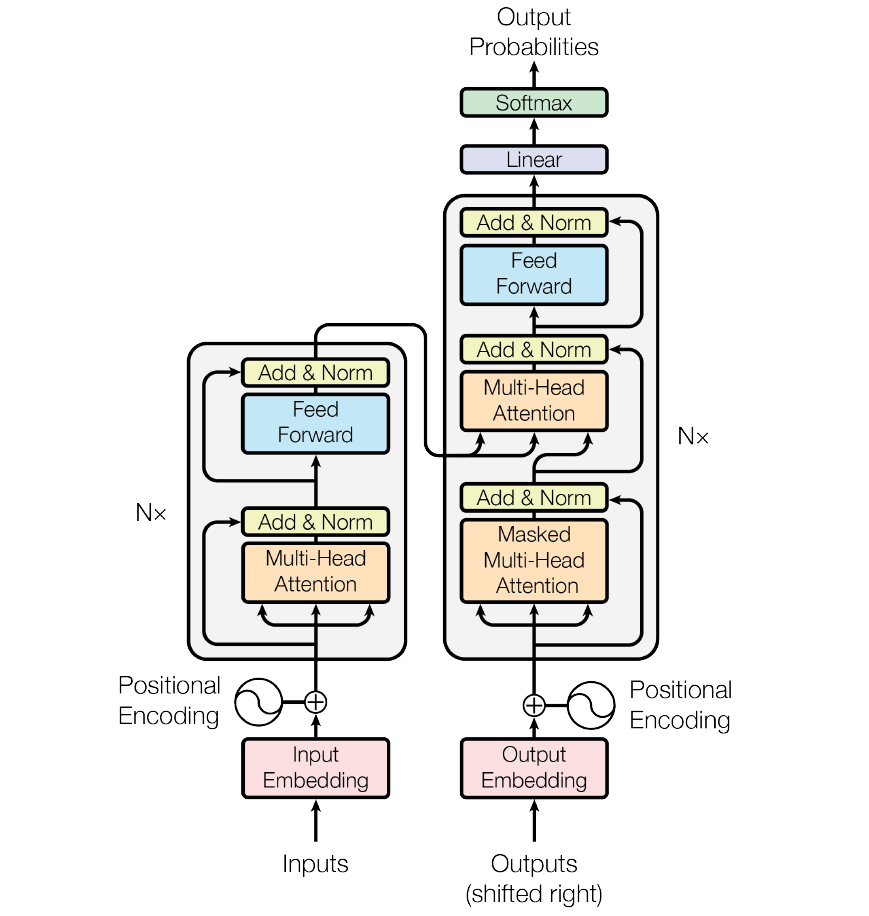

In [7]:
Image(filename='./pictures/2-transformer.png')

## Encoder部分和Decoder部分

### Encoder

编码器由N = 6个完全相同的层组成。

In [8]:
def clones(module, N):
    "产生N个完全相同的网络层"
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [10]:
class Encoder(nn.Module):
    "完整的Encoder包含N层"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "每一层的输入是x和mask"
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

编码器的每层encoder包含Self Attention 子层和FFNN子层，每个子层都使用了残差连接[(cite)](https://arxiv.org/abs/1512.03385)，和层标准化（layer-normalization） [(cite)](https://arxiv.org/abs/1607.06450)。先实现一下层标准化：

In [11]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

我们称呼子层为：$\mathrm{Sublayer}(x)$，每个子层的最终输出是$\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$。 dropout [(cite)](http://jmlr.org/papers/v15/srivastava14a.html)被加在Sublayer上。

为了便于进行残差连接，模型中的所有子层以及embedding层产生的输出的维度都为 $d_{\text{model}}=512$。

下面的SublayerConnection类用来处理单个Sublayer的输出，该输出将继续被输入下一个Sublayer：

In [13]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

每一层encoder都有两个子层。 第一层是一个multi-head self-attention层，第二层是一个简单的全连接前馈网络，对于这两层都需要使用SublayerConnection类进行处理。

In [17]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

解码器也是由N = 6 个完全相同的decoder层组成。  

In [18]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

单层decoder与单层encoder相比，decoder还有第三个子层，该层对encoder的输出执行attention：即encoder-decoder-attention层，q向量来自decoder上一层的输出，k和v向量是encoder最后层的输出向量。与encoder类似，我们在每个子层再采用残差连接，然后进行层标准化。

In [19]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

对于单层decoder中的self-attention子层，我们需要使用mask机制，以防止在当前位置关注到后面的位置。

In [23]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    print(subsequent_mask)
    return torch.from_numpy(subsequent_mask) == 0

> 下面的attention mask显示了每个tgt单词（行）允许查看（列）的位置。在训练时将当前单词的未来信息屏蔽掉，阻止此单词关注到后面的单词。

[[[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]]


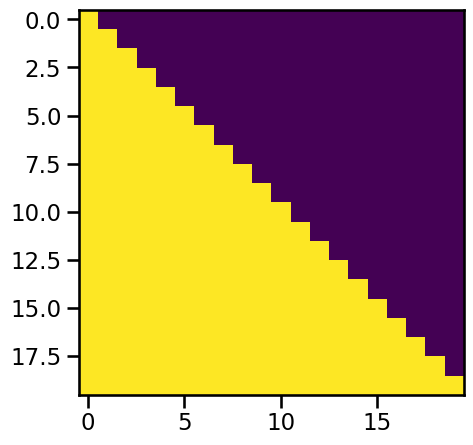

In [25]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

### Attention

Attention功能可以描述为将query和一组key-value映射到输出，其中query、key、value和输出都是向量。输出为value的加权和，其中每个value的权重通过query与相应key的计算得到。                                                                         
我们将particular attention称之为“缩放的点积Attention”(Scaled Dot-Product Attention")。其输入为query、key(维度是$d_k$)以及values(维度是$d_v$)。我们计算query和所有key的点积，然后对每个除以 $\sqrt{d_k}$, 最后用softmax函数获得value的权重。                                                                                                                                                                                                                                 
                                                                                                                                                                     

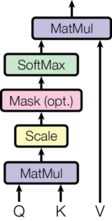

In [26]:
Image(filename='./pictures/transformer-self-attention.png')


在实践中，我们同时计算一组query的attention函数，并将它们组合成一个矩阵$Q$。key和value也一起组成矩阵$K$和$V$。 我们计算的输出矩阵为：
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

In [27]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

&#8195;&#8195;两个最常用的attention函数是：
- 加法attention[(cite)](https://arxiv.org/abs/1409.0473)
- 点积（乘法）attention

除了缩放因子$\frac{1}{\sqrt{d_k}}$ ，点积Attention跟我们的平时的点乘算法一样。加法attention使用具有单个隐层的前馈网络计算相似度。虽然理论上点积attention和加法attention复杂度相似，但在实践中，点积attention可以使用高度优化的矩阵乘法来实现，因此点积attention计算更快、更节省空间。                                                                                           
当$d_k$ 的值比较小的时候，这两个机制的性能相近。当$d_k$比较大时，加法attention比不带缩放的点积attention性能好  [(cite)](https://arxiv.org/abs/1703.03906)。我们怀疑，对于很大的$d_k$值, 点积大幅度增长，将softmax函数推向具有极小梯度的区域。(为了说明为什么点积变大，假设q和k是独立的随机变量，均值为0，方差为1。那么它们的点积$q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, 均值为0方差为$d_k$)。为了抵消这种影响，我们将点积缩小 $\frac{1}{\sqrt{d_k}}$倍。     

在此引用苏剑林文章[《浅谈Transformer的初始化、参数化与标准化》](https://zhuanlan.zhihu.com/p/400925524?utm_source=wechat_session&utm_medium=social&utm_oi=1400823417357139968&utm_campaign=shareopn)中谈到的，为什么Attention中除以$\sqrt{d}$这么重要？

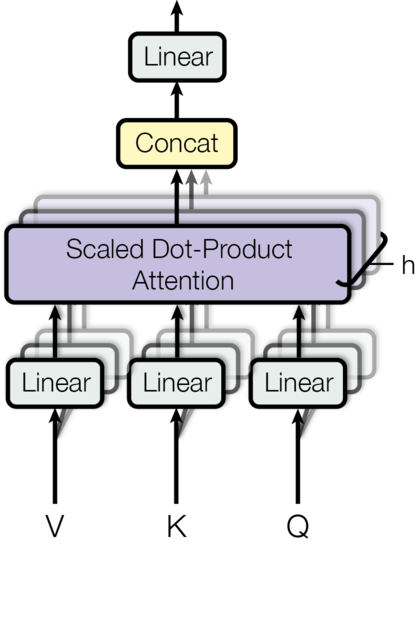

In [28]:
Image(filename='pictures/transformer-linear.png')

Multi-head attention允许模型同时关注来自不同位置的不同表示子空间的信息，如果只有一个attention head，向量的表示能力会下降。

$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                           

其中映射由权重矩阵完成：$W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$。 

 在这项工作中，我们采用$h=8$个平行attention层或者叫head。对于这些head中的每一个，我们使用$d_k=d_v=d_{\text{model}}/h=64$。由于每个head的维度减小，总计算成本与具有全部维度的单个head attention相似。 

In [30]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### 模型中Attention的应用

multi-head attention在Transformer中有三种不同的使用方式：                                                        
- 在encoder-decoder attention层中，queries来自前面的decoder层，而keys和values来自encoder的输出。这使得decoder中的每个位置都能关注到输入序列中的所有位置。这是模仿序列到序列模型中典型的编码器—解码器的attention机制，例如 [(cite)](https://arxiv.org/abs/1609.08144).    


- encoder包含self-attention层。在self-attention层中，所有key，value和query来自同一个地方，即encoder中前一层的输出。在这种情况下，encoder中的每个位置都可以关注到encoder上一层的所有位置。


- 类似地，decoder中的self-attention层允许decoder中的每个位置都关注decoder层中当前位置之前的所有位置（包括当前位置）。 为了保持解码器的自回归特性，需要防止解码器中的信息向左流动。我们在缩放点积attention的内部，通过屏蔽softmax输入中所有的非法连接值（设置为$-\infty$）实现了这一点。                                                                                                                                                                                                                                                     

### 基于位置的前馈网络

除了attention子层之外，我们的编码器和解码器中的每个层都包含一个全连接的前馈网络，该网络在每个层的位置相同（都在每个encoder-layer或者decoder-layer的最后）。该前馈网络包括两个线性变换，并在两个线性变换中间有一个ReLU激活函数。

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                        

尽管两层都是线性变换，但它们在层与层之间使用不同的参数。另一种描述方式是两个内核大小为1的卷积。 输入和输出的维度都是 $d_{\text{model}}=512$, 内层维度是$d_{ff}=2048$。（也就是第一层输入512维,输出2048维；第二层输入2048维，输出512维）

In [34]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax 

与其他seq2seq模型类似，我们使用学习到的embedding将输入token和输出token转换为$d_{\text{model}}$维的向量。我们还使用普通的线性变换和softmax函数将解码器输出转换为预测的下一个token的概率 在我们的模型中，两个嵌入层之间和pre-softmax线性变换共享相同的权重矩阵，类似于[(cite)](https://arxiv.org/abs/1608.05859)。在embedding层中，我们将这些权重乘以$\sqrt{d_{\text{model}}}$。                                                                                                                               

In [36]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## 位置编码                                                                                                                            
&#8195;&#8195;由于我们的模型不包含循环和卷积，为了让模型利用序列的顺序，我们必须加入一些序列中token的相对或者绝对位置的信息。为此，我们将“位置编码”添加到编码器和解码器堆栈底部的输入embeddinng中。位置编码和embedding的维度相同，也是$d_{\text{model}}$ , 所以这两个向量可以相加。有多种位置编码可以选择，例如通过学习得到的位置编码和固定的位置编码 [(cite)](https://arxiv.org/pdf/1705.03122.pdf)。

&#8195;&#8195;在这项工作中，我们使用不同频率的正弦和余弦函数：                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             $$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$                                                                                                                                                                                                                                                        
&#8195;&#8195;其中$pos$ 是位置，$i$ 是维度。也就是说，位置编码的每个维度对应于一个正弦曲线。 这些波长形成一个从$2\pi$ 到 $10000 \cdot 2\pi$的集合级数。我们选择这个函数是因为我们假设它会让模型很容易学习对相对位置的关注，因为对任意确定的偏移$k$, $PE_{pos+k}$ 可以表示为 $PE_{pos}$的线性函数。

&#8195;&#8195;此外，我们会将编码器和解码器堆栈中的embedding和位置编码的和再加一个dropout。对于基本模型，我们使用的dropout比例是$P_{drop}=0.1$。
                                                                                                                                                                                                                                                    


In [37]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

> 如下图，位置编码将根据位置添加正弦波。波的频率和偏移对于每个维度都是不同的。

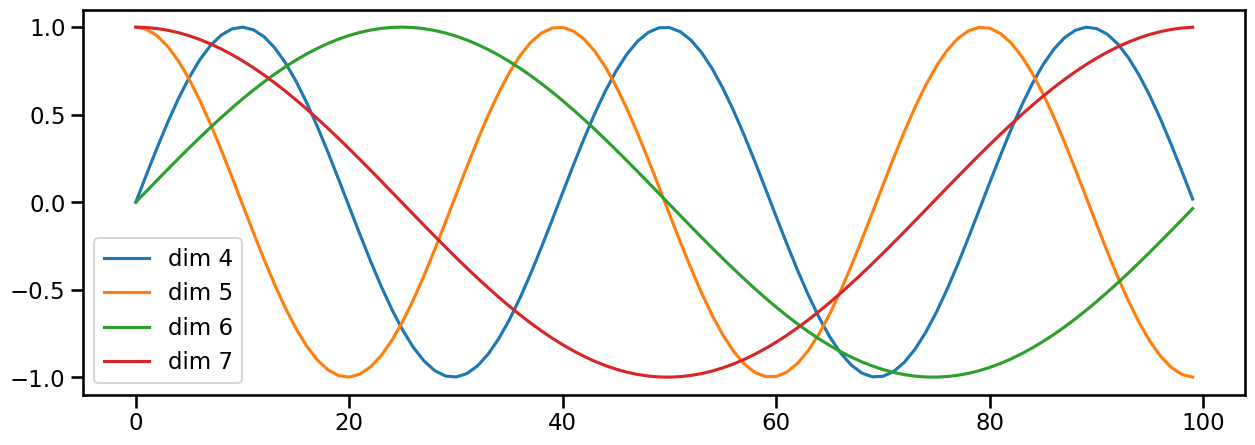

In [39]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

我们还尝试使用学习的位置embeddings[(cite)](https://arxiv.org/pdf/1705.03122.pdf)来代替固定的位置编码，结果发现两种方法产生了几乎相同的效果。于是我们选择了正弦版本，因为它可能允许模型外推到，比训练时遇到的序列更长的序列。

## 完整模型

> 在这里，我们定义了一个从超参数到完整模型的函数。

In [44]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [46]:
# Small example model.
tmp_model = make_model(10, 10, 2)
None

/var/folders/6v/1mg936zn2_5994vxxgrngk7c0000gn/T/ipykernel_49823/2289673833.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


# 训练

本节描述了我们模型的训练机制。

> 我们在这快速地介绍一些工具，这些工具用于训练一个标准的encoder-decoder模型。首先，我们定义一个批处理对象，其中包含用于训练的 src 和目标句子，以及构建掩码。

## 批处理和掩码

In [48]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

> 接下来我们创建一个通用的训练和评估函数来跟踪损失。我们传入一个通用的损失函数，也用它来进行参数更新。

## Training Loop

In [75]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## 训练数据和批处理
&#8195;&#8195;我们在包含约450万个句子对的标准WMT 2014英语-德语数据集上进行了训练。这些句子使用字节对编码进行编码，源语句和目标语句共享大约37000个token的词汇表。对于英语-法语翻译，我们使用了明显更大的WMT 2014英语-法语数据集，该数据集由 3600 万个句子组成，并将token拆分为32000个word-piece词表。<br>
每个训练批次包含一组句子对，句子对按相近序列长度来分批处理。每个训练批次的句子对包含大约25000个源语言的tokens和25000个目标语言的tokens。

> 我们将使用torch text进行批处理（后文会进行更详细地讨论）。在这里，我们在torchtext函数中创建批处理，以确保我们填充到最大值的批处理大小不会超过阈值（如果我们有8个gpu，则为25000）。

In [51]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## 硬件和训练时间
我们在一台配备8个 NVIDIA P100 GPU 的机器上训练我们的模型。使用论文中描述的超参数的base models，每个训练step大约需要0.4秒。我们对base models进行了总共10万steps或12小时的训练。而对于big models，每个step训练时间为1.0秒，big models训练了30万steps（3.5 天）。

## Optimizer

我们使用Adam优化器[(cite)](https://arxiv.org/abs/1412.6980)，其中 $\beta_1=0.9$, $\beta_2=0.98$并且$\epsilon=10^{-9}$。我们根据以下公式在训练过程中改变学习率：                                         
$$                                                                                                                                                                                                                                                                                         
lrate = d_{\text{model}}^{-0.5} \cdot                                                                                                                                                                                                                                                                                                
  \min({step\_num}^{-0.5},                                                                                                                                                                                                                                                                                                  
    {step\_num} \cdot {warmup\_steps}^{-1.5})                                                                                                                                                                                                                                                                               
$$                                                                                                                                                                                             
这对应于在第一次$warmup\_steps$步中线性地增加学习速率，并且随后将其与步数的平方根成比例地减小。我们使用$warmup\_steps=4000$。                            

> 注意：这部分非常重要。需要使用此模型设置进行训练。

In [77]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))


> 以下是此模型针对不同模型大小和优化超参数的曲线示例。

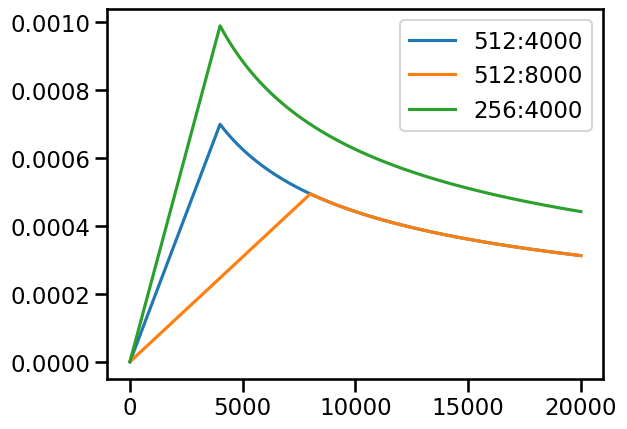

In [78]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## 正则化
### 标签平滑

在训练过程中，我们使用的label平滑的值为$\epsilon_{ls}=0.1$ [(cite)](https://arxiv.org/abs/1512.00567)。虽然对label进行平滑会让模型困惑，但提高了准确性和BLEU得分。

> 我们使用KL div损失实现标签平滑。我们没有使用one-hot独热分布，而是创建了一个分布，该分布设定目标分布为1-smoothing，将剩余概率分配给词表中的其他单词。

In [67]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

下面我们看一个例子，看看平滑后的真实概率分布。

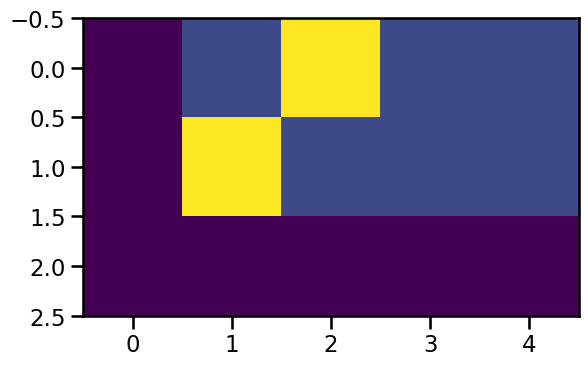

In [68]:
#Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

In [69]:
print(crit.true_dist)

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


由于标签平滑的存在，如果模型对于某个单词特别有信心，输出特别大的概率，会被惩罚。如下代码所示，随着输入x的增大，x/d会越来越大，1/d会越来越小，但是loss并不是一直降低的。

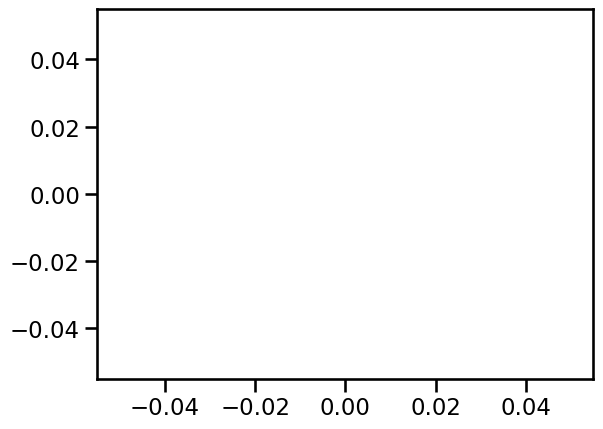

In [70]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item()

y = [loss(x) for x in range(1, 100)]
x = np.arange(1, 100)
plt.plot(x, y)

# 实例

> 我们可以从尝试一个简单的复制任务开始。给定来自小词汇表的一组随机输入符号symbols，目标是生成这些相同的符号。

## 合成数据

In [71]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

## 损失函数计算

In [72]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

## 贪婪解码

In [73]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

/var/folders/6v/1mg936zn2_5994vxxgrngk7c0000gn/T/ipykernel_49823/2289673833.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(p)


[[[0 1 1 1 1 1 1 1 1]
  [0 0 1 1 1 1 1 1 1]
  [0 0 0 1 1 1 1 1 1]
  [0 0 0 0 1 1 1 1 1]
  [0 0 0 0 0 1 1 1 1]
  [0 0 0 0 0 0 1 1 1]
  [0 0 0 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0]]]
[[[0 1 1 1 1 1 1 1 1]
  [0 0 1 1 1 1 1 1 1]
  [0 0 0 1 1 1 1 1 1]
  [0 0 0 0 1 1 1 1 1]
  [0 0 0 0 0 1 1 1 1]
  [0 0 0 0 0 0 1 1 1]
  [0 0 0 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0]]]
Epoch Step: 1 Loss: 3.190465 Tokens per Sec: 1899.896973
[[[0 1 1 1 1 1 1 1 1]
  [0 0 1 1 1 1 1 1 1]
  [0 0 0 1 1 1 1 1 1]
  [0 0 0 0 1 1 1 1 1]
  [0 0 0 0 0 1 1 1 1]
  [0 0 0 0 0 0 1 1 1]
  [0 0 0 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0]]]
[[[0 1 1 1 1 1 1 1 1]
  [0 0 1 1 1 1 1 1 1]
  [0 0 0 1 1 1 1 1 1]
  [0 0 0 0 1 1 1 1 1]
  [0 0 0 0 0 1 1 1 1]
  [0 0 0 0 0 0 1 1 1]
  [0 0 0 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0]]]
[[[0 1 1 1 1 1 1 1 1]
  [0 0 1 1 1 1 1 1 1]
  [0 0 0 1 1 1 1 1 1]
  [0 0 0 0 1 1 1 1 1]
  [0 0 0 0 0 1 1 1 1]
  [0 0 0 0 0 0 1 1 1]
  [0 0 0 0 

> 为了简单起见，此代码使用贪婪解码来预测翻译。

In [74]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

[[[0]]]
[[[0 1]
  [0 0]]]
[[[0 1 1]
  [0 0 1]
  [0 0 0]]]
[[[0 1 1 1]
  [0 0 1 1]
  [0 0 0 1]
  [0 0 0 0]]]
[[[0 1 1 1 1]
  [0 0 1 1 1]
  [0 0 0 1 1]
  [0 0 0 0 1]
  [0 0 0 0 0]]]
[[[0 1 1 1 1 1]
  [0 0 1 1 1 1]
  [0 0 0 1 1 1]
  [0 0 0 0 1 1]
  [0 0 0 0 0 1]
  [0 0 0 0 0 0]]]
[[[0 1 1 1 1 1 1]
  [0 0 1 1 1 1 1]
  [0 0 0 1 1 1 1]
  [0 0 0 0 1 1 1]
  [0 0 0 0 0 1 1]
  [0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0]]]
[[[0 1 1 1 1 1 1 1]
  [0 0 1 1 1 1 1 1]
  [0 0 0 1 1 1 1 1]
  [0 0 0 0 1 1 1 1]
  [0 0 0 0 0 1 1 1]
  [0 0 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0]]]
[[[0 1 1 1 1 1 1 1 1]
  [0 0 1 1 1 1 1 1 1]
  [0 0 0 1 1 1 1 1 1]
  [0 0 0 0 1 1 1 1 1]
  [0 0 0 0 0 1 1 1 1]
  [0 0 0 0 0 0 1 1 1]
  [0 0 0 0 0 0 0 1 1]
  [0 0 0 0 0 0 0 0 1]
  [0 0 0 0 0 0 0 0 0]]]
tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])


# 真实场景示例
由于原始jupyter的真实数据场景需要多GPU训练，本教程暂时不将其纳入，感兴趣的读者可以继续阅读[原始教程](https://nlp.seas.harvard.edu/2018/04/03/attention.html)。另外由于真实数据原始url失效，原始教程应该也无法运行真实数据场景的代码。

# 结语

到目前为止，我们逐行实现了一个完整的Transformer，并使用合成的数据对其进行了训练和预测，希望这个教程能对你有帮助。

# 致谢
本文由张红旭同学翻译，由多多同学整理，原始jupyter来源于哈佛NLP [The annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)。

<div id="disqus_thread"></div>
<script>
    /**
     *  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
     *  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
     */
    /*
    var disqus_config = function () {
        this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
        this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
    };
    */
    (function() {  // REQUIRED CONFIGURATION VARIABLE: EDIT THE SHORTNAME BELOW
        var d = document, s = d.createElement('script');
        
        s.src = 'https://EXAMPLE.disqus.com/embed.js';  // IMPORTANT: Replace EXAMPLE with your forum shortname!
        
        s.setAttribute('data-timestamp', +new Date());
        (d.head || d.body).appendChild(s);
    })();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript" rel="nofollow">comments powered by Disqus.</a></noscript>